In [1]:
# This file makes a basic attempt to make a simplified version of the lomb-scargle approximation of periodicity
# as in Clark and Nolan 2024
import spikeinterface.full as si
from probeinterface.plotting import plot_probe, plot_probegroup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec
from scipy import stats
import os
from Helpers import plot_utility
from P2_PostProcess.VirtualReality.plotting import get_vmin_vmax, min_max_normalize
from P2_PostProcess.VirtualReality.spatial_information import calculate_spatial_information
import time
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
from astropy.timeseries import LombScargle
from astropy.convolution import convolve, Gaussian1DKernel
from astropy.nddata import block_reduce
from P2_PostProcess.VirtualReality.plotting import plot_firing_rate_maps_per_trial_2
# Periodgram settings
frequency_step = 0.02
max_frequency = 5
frequency = np.arange(0.1, max_frequency+frequency_step, frequency_step) # spatial freqs to test for
window_length_in_laps = 3 # n trials (laps)
power_estimate_step = 20 # cm
track_length = 200
sliding_window_size=track_length*window_length_in_laps # cm

In [2]:

def distance_from_integer(frequencies):
    distance_from_zero = np.asarray(frequencies)%1
    distance_from_one = 1-(np.asarray(frequencies)%1)
    tmp = np.vstack((distance_from_zero, distance_from_one))
    return np.min(tmp, axis=0)

def lomb_scargle(spike_data, processed_position_data):
    n_trials = len(processed_position_data)
    elapsed_distance_bins = np.arange(0, (track_length*n_trials)+1, 1)
    elapsed_distance = 0.5*(elapsed_distance_bins[1:]+elapsed_distance_bins[:-1])/track_length

    all_powers = []
    all_centre_distances = []
    all_freqs = []
    all_deltas = []
    for cluster_index, cluster_id in enumerate(spike_data.cluster_id):
        cluster_spike_data = spike_data[spike_data["cluster_id"] == cluster_id]
        firing_rates = np.array(cluster_spike_data["fr_binned_in_space_smoothed"].iloc[0])
        bin_centres = np.array(cluster_spike_data["fr_binned_in_space_bin_centres"].iloc[0])
        firing_times_cluster = np.array(cluster_spike_data["firing_times_vr"].iloc[0])

        time_then = time.time()
        if len(firing_times_cluster)>1:
            fr = firing_rates.flatten()

            powers = []
            centre_distances = []
            indices_to_test = np.arange(0, len(fr)-sliding_window_size, 1, dtype=np.int64)[::power_estimate_step]
            for m in indices_to_test:
                ls = LombScargle(elapsed_distance[m:m+sliding_window_size], fr[m:m+sliding_window_size])
                power = ls.power(frequency)
                powers.append(power.tolist())
                centre_distances.append(np.nanmean(elapsed_distance[m:m+sliding_window_size]))
            powers = np.array(powers)
            centre_distances = np.array(centre_distances)
            centre_trials = np.round(np.array(centre_distances)).astype(np.int64)

            powers[np.isnan(powers)] = 0
            max_power_freqs = []
            for i in range(len(powers)):
                a = frequency[np.nanargmax(powers[i])]
                max_power_freqs.append(a)
            max_power_freqs = np.array(max_power_freqs)
            dist_from_spatial_freq_int = distance_from_integer(max_power_freqs)
            all_centre_distances.append(centre_distances)
            all_freqs.append(max_power_freqs)
            all_deltas.append(dist_from_spatial_freq_int)
            all_powers.append(powers)
        else:
            all_centre_distances.append([])
            all_freqs.append([])
            all_deltas.append([])
            all_powers.append([])

        time_taken = time_then-time.time()
        print(f'time for cluster {cluster_id} is {time.time()-time_then}, seconds')

    spike_data["ls_powers"] = all_powers
    spike_data["ls_centre_distances"] = all_centre_distances
    spike_data["ls_freqs"] = all_freqs
    spike_data["ls_deltas"] = all_deltas
    return spike_data

def plot_lomb_scargle(spike_data): 
    periodograms = []
    for cluster_index, cluster_id in enumerate(spike_data.cluster_id):
        cluster_spike_data = spike_data[spike_data["cluster_id"] == cluster_id]
        firing_times_cluster = np.array(cluster_spike_data["firing_times_vr"].iloc[0])

        if len(firing_times_cluster)>1:
            powers = np.array(cluster_spike_data["ls_powers"].iloc[0])
            centre_xs = np.array(cluster_spike_data["ls_centre_distances"].iloc[0])
            periodograms.append(powers.T)

    nrows = int(np.ceil(np.sqrt(len(spike_data))))
    ncols = nrows; i=0; j=0
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 20), squeeze=False)
    Y, X = np.meshgrid(centre_xs, frequency) 
    cmap = plt.cm.get_cmap("inferno")
    for periodogram in periodograms:
        vmin, vmax = get_vmin_vmax(periodogram)
        for f in range(1,5):
            ax[j, i].axvline(x=f, color="white", linewidth=0.5,linestyle="dotted")
        ax[j, i].pcolormesh(X, Y, periodogram, cmap=cmap, shading="auto", vmin=vmin, vmax=vmax)
        i+=1
        if i==ncols:
            i=0; j+=1
    for j in range(nrows):
        for i in range(ncols):
            ax[j, i].spines['top'].set_visible(False) 
            ax[j, i].spines['right'].set_visible(False)
            ax[j, i].spines['bottom'].set_visible(False)
            ax[j, i].spines['left'].set_visible(False)
            ax[j, i].set_xticks([])
            ax[j, i].set_yticks([])
            ax[j, i].xaxis.set_tick_params(labelbottom=False)
            ax[j, i].yaxis.set_tick_params(labelleft=False)
    plt.show()
  



In [3]:
def get_data(vr_session_base_names, of_session_base_names, curate=True):
    project_path = "/mnt/datastore/Harry/Cohort11_april2024/derivatives/"
    
    master_data = pd.DataFrame()
    for vr_name, of_name in zip(vr_session_base_names, of_session_base_names):
        mouse = vr_name.split("_")[0]
        day = vr_name.split("_")[1]
        vr_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/kilosort4/spikes.pkl"
        of_path = f"{project_path}{mouse}/{day}/of/{of_name}/processed/kilosort4/spikes.pkl"
        sorting_analyzer_path = f"{project_path}{mouse}/{day}/ephys/sorting_analyzer"
        spike_data_vr = pd.read_pickle(vr_path); spike_data_vr["firing_times_vr"] = spike_data_vr["firing_times"]
        spike_data_of = pd.read_pickle(of_path); spike_data_of["firing_times_of"] = spike_data_of["firing_times"]
        spike_data = pd.merge(spike_data_vr, spike_data_of, on="cluster_id")

        sorting_analyzer = si.load_sorting_analyzer(sorting_analyzer_path)
        ulc = sorting_analyzer.get_extension("unit_locations")
        unit_locations = ulc.get_data(outputs="by_unit")
        spike_data['unit_location_x'] = (spike_data.index.map(lambda unit: unit_locations[unit][0])*-1)+750+40
        spike_data['unit_location_y'] = spike_data.index.map(lambda unit: unit_locations[unit][1])
        spike_data['unit_location_z'] = spike_data.index.map(lambda unit: unit_locations[unit][2])

        position_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/position_data.csv"
        processed_position_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/processed_position_data.pkl"
        position_data = pd.read_csv(position_path)
        processed_position_data = pd.read_pickle(processed_position_path)
        spike_data = spike_data.sort_values(by=["grid_score"], ascending=False)

        print(f"for {mouse} {day}, there are {len(spike_data)}")
        if curate:
            spike_data = spike_data[(spike_data["snr_x"] > 1) & 
                                    (spike_data["mean_firing_rate_x"] > 0.5) & 
                                    (spike_data["rp_contamination_x"] < 0.9) &
                                    (spike_data["sd_ratio_x"] > 1)]
            print(f"after curation, there are {len(spike_data)}")
        spike_data = calculate_spatial_information(spike_data, position_data, track_length=200)
        #spike_data = lomb_scargle(spike_data, processed_position_data)
        master_data = pd.concat([master_data, spike_data],ignore_index=True)
    return master_data

In [4]:
def plot_rate_maps(spike_data):
    if "firing_times_vr" in list(spike_data):
        fr_col = "firing_times_vr"
    else:
        fr_col = "firing_times"
        
    rate_maps = []
    for cluster_index, cluster_id in enumerate(spike_data.cluster_id):
        firing_times_cluster = spike_data[fr_col].iloc[cluster_index]

        if len(firing_times_cluster)>1:
            cluster_firing_maps = np.array(spike_data['fr_binned_in_space_smoothed'].iloc[cluster_index])
            cluster_firing_maps[np.isnan(cluster_firing_maps)] = 0
            cluster_firing_maps[np.isinf(cluster_firing_maps)] = 0
            percentile_99th_display = np.nanpercentile(cluster_firing_maps, 95);
            cluster_firing_maps = min_max_normalize(cluster_firing_maps)
            percentile_99th = np.nanpercentile(cluster_firing_maps, 95); 
            cluster_firing_maps = np.clip(cluster_firing_maps, a_min=0, a_max=percentile_99th)
            vmin, vmax = get_vmin_vmax(cluster_firing_maps)
            rate_maps.append(cluster_firing_maps)

    print(len(cluster_firing_maps))
    cmap = plt.cm.get_cmap("viridis")
    nrows = int(np.ceil(np.sqrt(len(spike_data))))
    ncols = nrows; i=0; j=0;
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 20), squeeze=False)
    for m, rate_map in enumerate(rate_maps):
        vmin, vmax = get_vmin_vmax(rate_map)
        locations = np.arange(0, len(rate_map[0]))
        ordered = np.arange(0, len(rate_map), 1)
        X, Y = np.meshgrid(locations, ordered)
        ax[j, i].pcolormesh(X, Y, rate_map, cmap=cmap, shading="auto", vmin=vmin, vmax=vmax)
        #ax[j, i].text(0,0, spike_data["cluster_id"].iloc[m],color="white", fontsize=15)
        i+=1
        if i==ncols:
            i=0; j+=1
    for j in range(nrows):
        for i in range(ncols):
            ax[j, i].spines['top'].set_visible(False)
            ax[j, i].spines['right'].set_visible(False)
            ax[j, i].spines['bottom'].set_visible(False)
            ax[j, i].spines['left'].set_visible(False)
            ax[j, i].set_xticks([])
            ax[j, i].set_yticks([])
            ax[j, i].xaxis.set_tick_params(labelbottom=False)
            ax[j, i].yaxis.set_tick_params(labelleft=False)
    plt.subplots_adjust(hspace=.1, wspace=.1, bottom=None, left=None, right=None, top=None)
    plt.show()

def plot_of_rate_maps(spike_data):

    rate_maps = []
    for cluster_index, cluster_id in enumerate(spike_data.cluster_id):
        cluster_df = spike_data[(spike_data.cluster_id == cluster_id)] # dataframe for that cluster
        firing_rate_map_original = cluster_df['firing_maps'].iloc[0]
        occupancy_map = cluster_df['occupancy_maps'].iloc[0]
        firing_rate_map_original[occupancy_map==0] = np.nan
        firing_rate_map = np.rot90(firing_rate_map_original)
        rate_maps.append(firing_rate_map)
 
    nrows = int(np.ceil(np.sqrt(len(spike_data))))
    ncols = nrows; i=0; j=0; 
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 20), squeeze=False)
    cmap = plt.cm.get_cmap("jet")
    cmap.set_bad("white")
    for rate_map in rate_maps:
        ax[j, i].imshow(rate_map, cmap=cmap, interpolation='nearest')
        i+=1
        if i==ncols:
            i=0; j+=1
    for j in range(nrows):
        for i in range(ncols):
            ax[j, i].spines['top'].set_visible(False)
            ax[j, i].spines['right'].set_visible(False)
            ax[j, i].spines['bottom'].set_visible(False)
            ax[j, i].spines['left'].set_visible(False)
            ax[j, i].set_xticks([])
            ax[j, i].set_yticks([])
            ax[j, i].xaxis.set_tick_params(labelbottom=False)
            ax[j, i].yaxis.set_tick_params(labelleft=False)
    plt.show()


In [5]:
spike_data = get_data(vr_session_base_names =["M21_D26_2024-05-28_17-04-41_VR1"],
                      of_session_base_names = ["M21_D26_2024-05-28_16-35-31_OF1"])
spike_data = spike_data[spike_data["unit_location_y"] < 2200]
spike_data = spike_data.sort_values(by=["grid_score"], ascending=False)
#plot_rate_maps(spike_data)
#plot_lomb_scargle(spike_data)
#plot_of_rate_maps(spike_data)   

for M21 D26, there are 419
after curation, there are 182


for M20 D25, there are 232
after curation, there are 43
time for cluster 156 is 6.022825241088867, seconds
time for cluster 159 is 6.075363874435425, seconds
time for cluster 161 is 5.835453510284424, seconds
time for cluster 104 is 5.737724542617798, seconds
time for cluster 119 is 5.74222469329834, seconds
time for cluster 96 is 5.733892440795898, seconds
time for cluster 164 is 5.786376476287842, seconds
time for cluster 70 is 5.765794038772583, seconds
time for cluster 166 is 5.850912809371948, seconds
time for cluster 127 is 5.747899293899536, seconds
time for cluster 109 is 5.8028223514556885, seconds
time for cluster 84 is 5.764419317245483, seconds
time for cluster 154 is 5.7760865688323975, seconds
time for cluster 153 is 5.757766246795654, seconds
time for cluster 174 is 5.8018457889556885, seconds
time for cluster 105 is 5.795569896697998, seconds
time for cluster 170 is 5.787203550338745, seconds
time for cluster 83 is 5.786850690841675, seconds
time for cluster 158 is 5.76

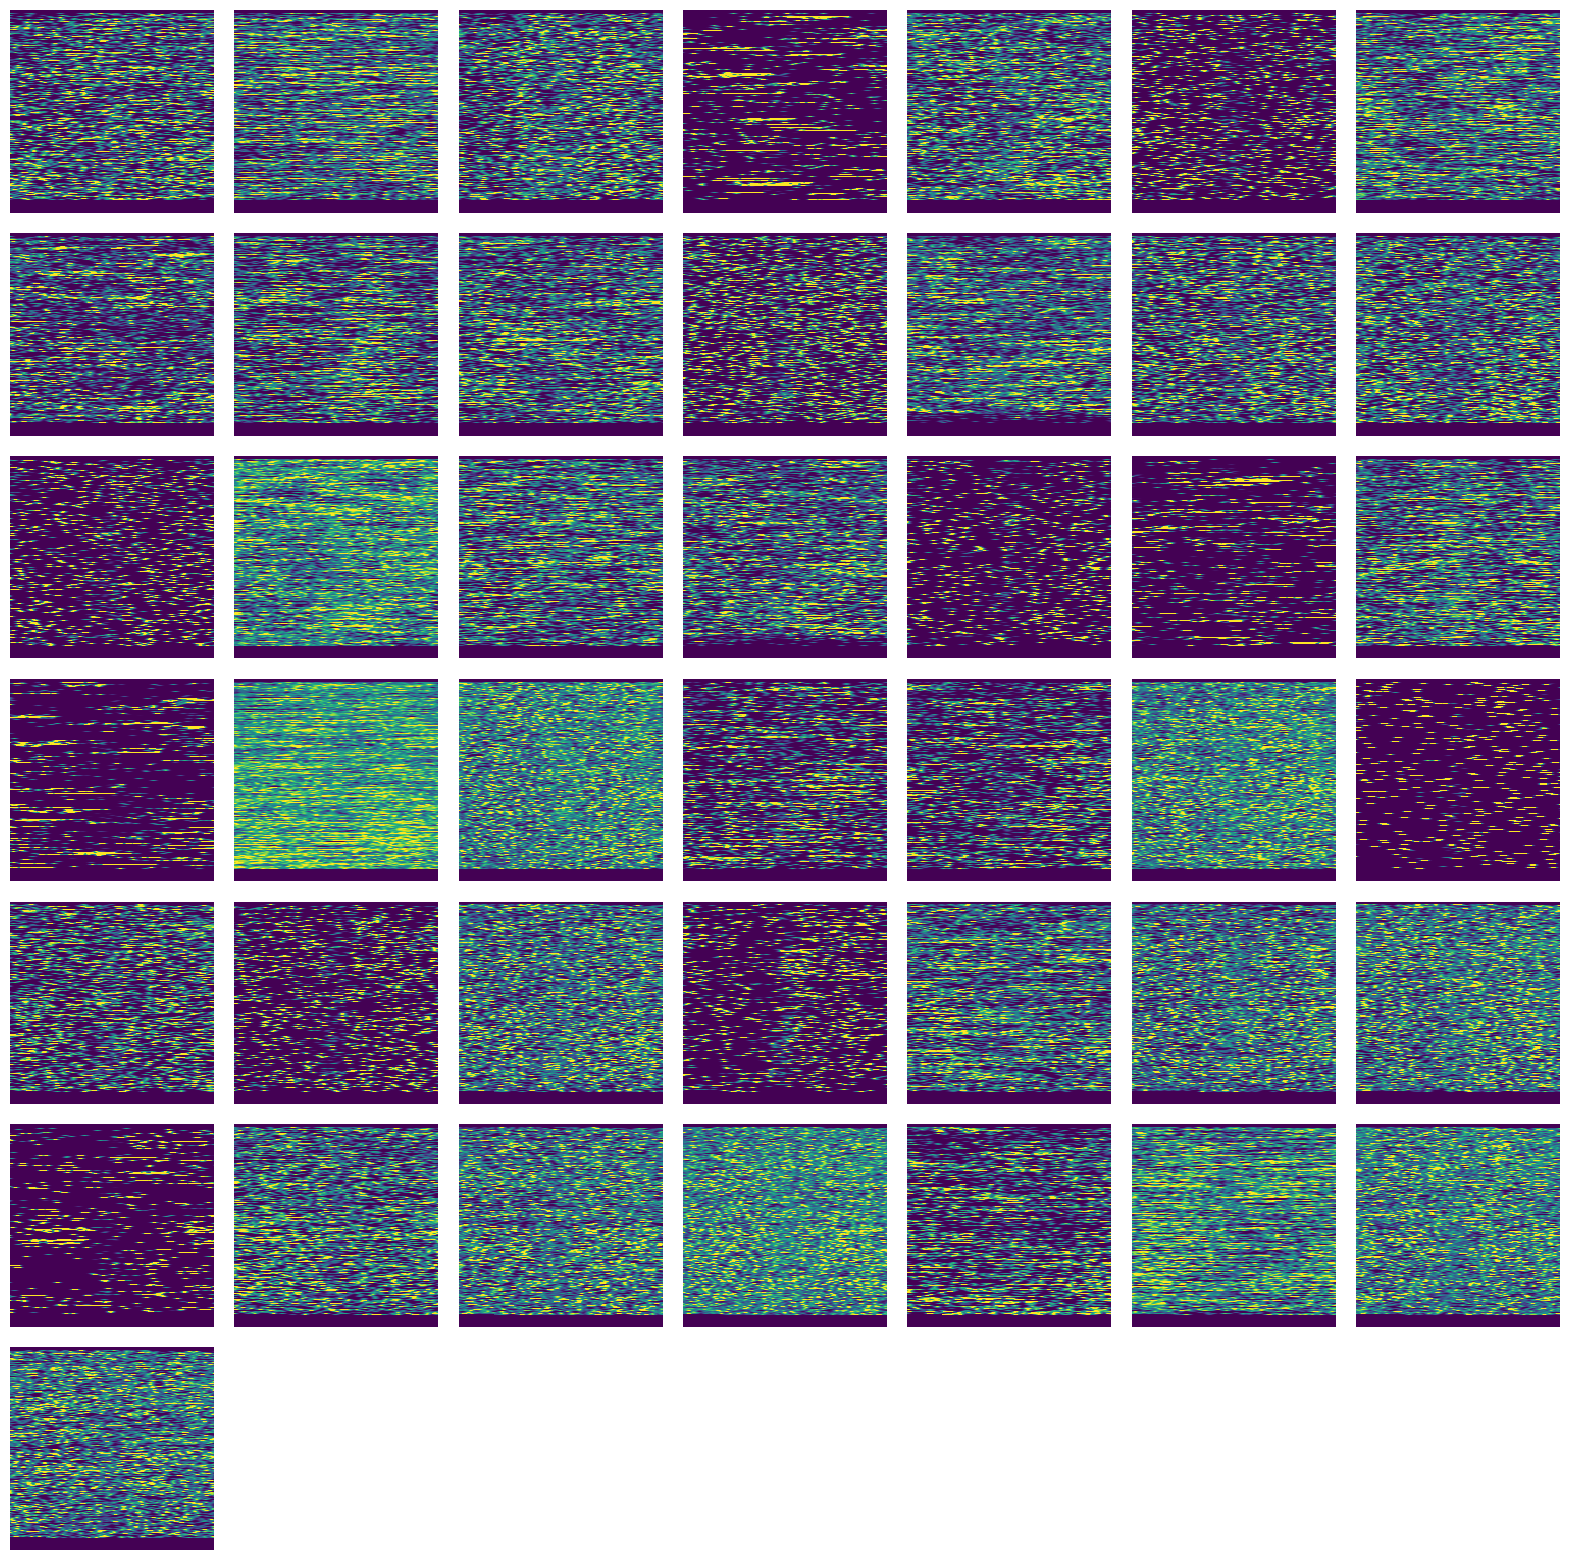

In [13]:
spike_data = get_data(vr_session_base_names =["M20_D25_2024-05-27_14-24-21_VR1"],
                      of_session_base_names = ["M20_D25_2024-05-27_13-57-19_OF1"])
spike_data = spike_data[spike_data["unit_location_y"] < 2200]
spike_data = spike_data.sort_values(by=["grid_score"], ascending=False)
plot_rate_maps(spike_data)
plot_lomb_scargle(spike_data)
plot_of_rate_maps(spike_data)